## Fine-tuning d'un modèle BioBERT pré-entrainé 
Import des dépendances

In [68]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,confusion_matrix,accuracy_score
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

Import des données

In [69]:
dataset=pd.read_csv("data/medical-abstracts-dataset.csv")

#We delete the class "general pathological conditions"
dataset=dataset[dataset["condition_label"]!="general pathological conditions"]


Détails de la base de données

In [70]:


# Print first lines of the dataset to get an idea of its structure
print(dataset.head())

# Verify the general infos of the dataset ( data types, missing values)
print(dataset.info())

# Infos on texts lengths
dataset['abstract_length'] = dataset['medical_abstract'].apply(len)
print("Longueur moyenne des abstracts:", dataset['abstract_length'].mean())
print("Longueur minimale des abstracts:", dataset['abstract_length'].min())
print("Longueur maximale des abstracts:", dataset['abstract_length'].max())
    
print("\nDistribution des longueurs des résumés:")
print(dataset['abstract_length'].describe())

length_by_label = dataset.groupby('condition_label')['abstract_length'].mean()
    
print(length_by_label)
    
length_by_label_stats = dataset.groupby('condition_label')['abstract_length'].describe()
print("\nStatistiques détaillées de la longueur des résumés par label:")
print(length_by_label_stats)

print("\nValeurs manquantes par colonne:")
print(dataset.isnull().sum())

           condition_label                                   medical_abstract
0  cardiovascular diseases  Coronary artery bypass grafting in a patient w...
1  cardiovascular diseases  Conservative management of aortic lacerations ...
2  cardiovascular diseases  Sudden death from acute cocaine intoxication i...
3  cardiovascular diseases  Catheterization of coronary artery bypass graf...
4  cardiovascular diseases  Spontaneous rupture of an aortic aneurysm into...
<class 'pandas.core.frame.DataFrame'>
Index: 1686 entries, 0 to 2285
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   condition_label   1686 non-null   object
 1   medical_abstract  1686 non-null   object
dtypes: object(2)
memory usage: 39.5+ KB
None
Longueur moyenne des abstracts: 563.85290628707
Longueur minimale des abstracts: 170
Longueur maximale des abstracts: 800

Distribution des longueurs des résumés:
count    1686.000000
mean      563.852

Mapping des labels pour s'adapter au modèle

In [71]:

LABEL_MAPPING = {
        "cardiovascular diseases": 0,
        "digestive system diseases": 1,
        "nervous system diseases": 2,
        "neoplasms": 3
}


Afficher la répartition des labels

C:\Users\Home\AppData\Local\Temp\ipykernel_20756\2405385352.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset["condition_label"], palette="viridis")


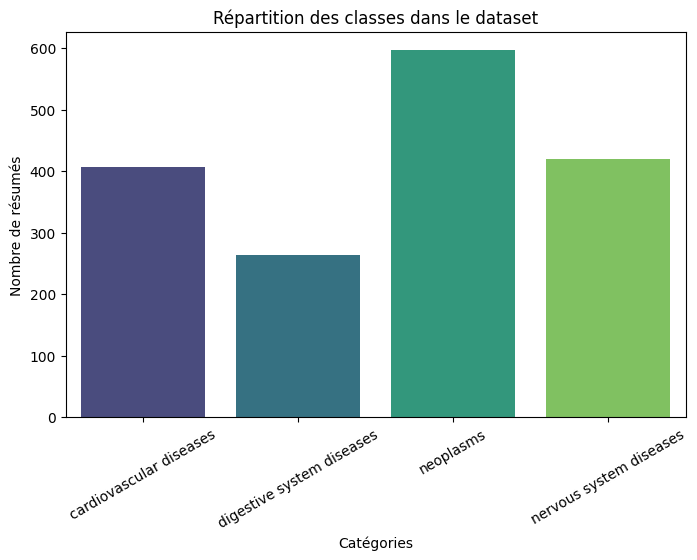

In [72]:

# Display classes repartition
plt.figure(figsize=(8, 5))
sns.countplot(x=dataset["condition_label"], palette="viridis")
plt.xlabel("Catégories")
plt.ylabel("Nombre de résumés")
plt.title("Répartition des classes dans le dataset")
plt.xticks(rotation=30)
plt.show()

repart=dataset.groupby(['condition_label']).count()

dataset["condition_label"] = dataset["condition_label"].map(LABEL_MAPPING)

# Inverse mapping to find real labels (further utilisation)
inverse_label_mapping = {v: k for k, v in LABEL_MAPPING.items()}

Réequilibrer les classes par sur-échantillonage (duplication des classes minoritaires)

In [73]:


# Find the major class
counter = Counter(dataset["condition_label"])
max_samples = max(counter.values())


# Reequilibrate classes by duplication
augmented_data = {"medical_abstract": [], "condition_label": []}
for label in counter:
    texts = [t for t, l in zip(dataset["medical_abstract"], dataset["condition_label"]) if l == label]
    
    num_full_copies = max_samples // counter[label]  # Copies
    remainder = max_samples % counter[label]         # Rest to add
    
    augmented_data["medical_abstract"].extend(texts * num_full_copies)
    augmented_data["condition_label"].extend([label] * len(texts) * num_full_copies)
    
    # Add randomly the rest to egalise
    extra_texts = texts[:remainder]  
    augmented_data["medical_abstract"].extend(extra_texts)
    augmented_data["condition_label"].extend([label] * len(extra_texts))

# Create the equilibrate dataset
dataset = Dataset.from_dict(augmented_data)
print(Counter(dataset["condition_label"]))  # Verification 

Counter({0: 596, 1: 596, 3: 596, 2: 596})


Modèle BioBERT, basé sur BERT et pré-entrainé sur des corpus médicaux

In [74]:

model_name="dmis-lab/biobert-base-cased-v1.1"

Vectorisation des données

In [75]:


labels=list(dataset["condition_label"])
Article_train=list(dataset["medical_abstract"])

max_length=512   # max length of Bert

tokenizer = AutoTokenizer.from_pretrained(model_name,do_lower_case=True)

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True)

print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


Séparation données train/valid (train : 0.8, valid:0.2)

In [76]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.2)

Transformation des bases en tensors

In [37]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)


Définition du modèle

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=4)

batch_size = 16 # Batch size for training and evaluation

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Définition des datasets passés au modèle

In [39]:
# Put in Dataset structure as it is the format accepted by Trainer method

train_dataset = Dataset.from_dict({
    'input_ids': train_inputs.tolist(),
    'attention_mask': train_masks.tolist(),
    'labels': train_labels.tolist()
})

val_dataset = Dataset.from_dict({
    'input_ids': validation_inputs.tolist(),
    'attention_mask': validation_masks.tolist(),
    'labels': validation_labels.tolist()
})

Définition d'un data collator

In [40]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Paramètres du trainer

In [41]:

training_args = TrainingArguments(
    "test-trainer",
    num_train_epochs=5,               # Number of epochs
    per_device_train_batch_size=16,    # Batch size
    per_device_eval_batch_size=16,      # Batch size             
    weight_decay=0.01,
    learning_rate=1e-5,
    warmup_steps=100,                    
    eval_strategy="epoch",         
    save_strategy="epoch",               
    load_best_model_at_end=True,
    metric_for_best_model="loss",         
)

Fonction pour retourner les métriques

In [42]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}



Définition du trainer

In [43]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\Home\AppData\Local\Temp\ipykernel_20756\4177837641.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entraînement du trainer

In [44]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.032787,0.706499
2,No log,0.519093,0.807128
3,No log,0.479472,0.813417
4,No log,0.464705,0.823899
5,0.678000,0.472669,0.815514


TrainOutput(global_step=600, training_loss=0.6111521339416504, metrics={'train_runtime': 438.0938, 'train_samples_per_second': 21.765, 'train_steps_per_second': 1.37, 'total_flos': 1156404131482080.0, 'train_loss': 0.6111521339416504, 'epoch': 5.0})


Sauvegarde du modèle

In [45]:
trainer.save_model("final_model")

Récupération des logs de l'entraînement

In [46]:
train_logs = trainer.state.log_history              # trainer logs

train_loss = [log['loss'] for log in train_logs if 'loss' in log]           
eval_loss = [log['eval_loss'] for log in train_logs if 'eval_loss' in log]
accuracy = [log['eval_accuracy'] for log in train_logs if 'eval_accuracy' in log]

epochs = [log['epoch'] for log in train_logs if 'epoch' in log]
epochs=epochs[:-1]                  # last epoch is doubled
if len(epochs)>5:                   # sometimes an intermediate epoch is inserted...
    epochs.pop(4)

Affichage des résultats obtenus au cours des époques

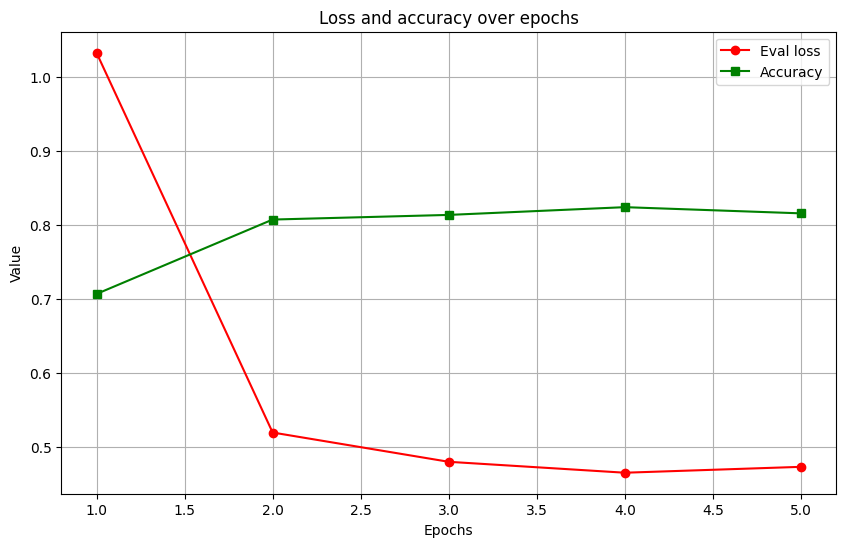

In [47]:
# Display loss and accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_loss, label="Eval loss", color="red", marker="o")
#plt.plot(epochs, train_loss, label="Train Loss", color="blue", marker="x")
plt.plot(epochs, accuracy, label="Accuracy", color="green", marker="s")
plt.title("Loss and accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Métriques d'évaluation

In [48]:

metrics = trainer.evaluate()            # Evaluate mode
print(metrics)

{'eval_loss': 0.464704692363739, 'eval_accuracy': 0.8238993710691824, 'eval_runtime': 4.8891, 'eval_samples_per_second': 97.564, 'eval_steps_per_second': 6.136, 'epoch': 5.0}


Affichage de l'accuracy et du rapport de classification

In [49]:




# Predict on validation dataset
predictions_output = trainer.predict(val_dataset)

# Extract logits of prediction
logits = predictions_output.predictions
# Predicted class is the one with the highets probability
predicted_classes = np.argmax(logits, axis=1)

# map index with real classes
predicted_labels = [inverse_label_mapping[idx] for idx in predicted_classes]
true_labels_encoded = val_dataset["labels"]
true_labels = [inverse_label_mapping[idx] for idx in true_labels_encoded]

# Generate classification report
report = classification_report(y_true=true_labels, y_pred=predicted_labels)

# Display results
print(" Prédictions sur le dataset de validation :")
print(predicted_labels)

print("\n Rapport de classification :")
print(report)


 Prédictions sur le dataset de validation :
['nervous system diseases', 'neoplasms', 'digestive system diseases', 'neoplasms', 'digestive system diseases', 'nervous system diseases', 'neoplasms', 'digestive system diseases', 'nervous system diseases', 'neoplasms', 'digestive system diseases', 'digestive system diseases', 'nervous system diseases', 'nervous system diseases', 'cardiovascular diseases', 'cardiovascular diseases', 'neoplasms', 'digestive system diseases', 'nervous system diseases', 'digestive system diseases', 'digestive system diseases', 'digestive system diseases', 'digestive system diseases', 'digestive system diseases', 'nervous system diseases', 'nervous system diseases', 'neoplasms', 'digestive system diseases', 'cardiovascular diseases', 'neoplasms', 'digestive system diseases', 'nervous system diseases', 'neoplasms', 'cardiovascular diseases', 'cardiovascular diseases', 'nervous system diseases', 'cardiovascular diseases', 'cardiovascular diseases', 'digestive syst

Matrice de confusion

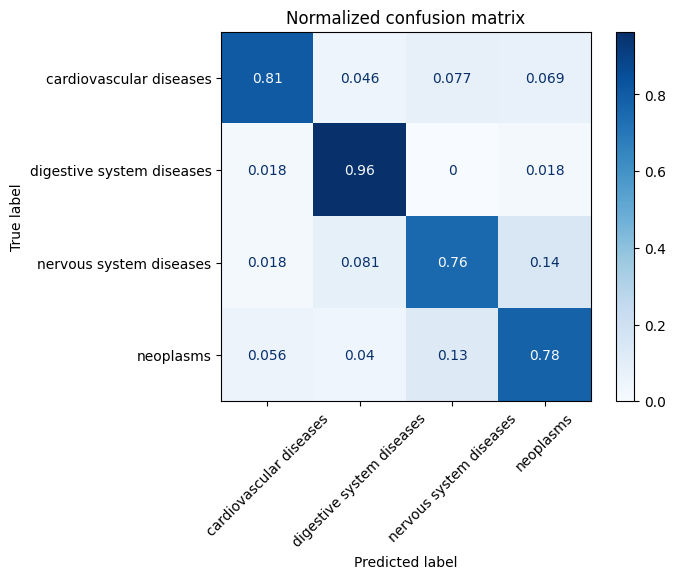

In [51]:


display_labels = list(LABEL_MAPPING.keys())

# Generate confusion matrix
cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels, normalize="true")

# Display the normalized confusion matrix
confplot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=display_labels)
confplot.plot(cmap="Blues")
plt.title("Normalized confusion matrix")
plt.xticks(rotation=45) 
plt.show()


Affichage de la courbe ROC

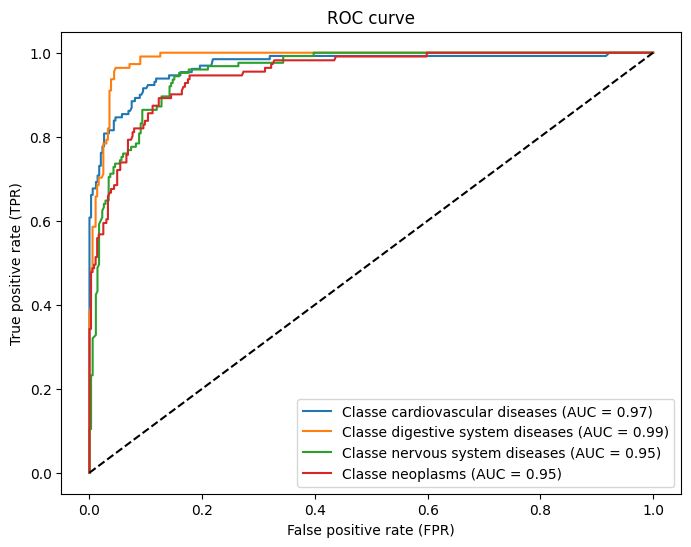

In [52]:
# Binarize the true labels for ROC OvR (One-vs-Rest)
y_true_bin = label_binarize(true_labels_encoded, classes=list(LABEL_MAPPING.values()))

# Convert logits in probabilies with softmax function
import torch.nn.functional as F
probs = F.softmax(torch.tensor(logits), dim=1).numpy()

# Display the curves
plt.figure(figsize=(8, 6))

for i, label in enumerate(LABEL_MAPPING.keys()):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Classe {label} (AUC = {roc_auc:.2f})")

# Random line x=y
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False positive rate (FPR)")
plt.ylabel("True positive rate (TPR)")
plt.title("ROC curve")
plt.legend()
plt.show()

-----------------------------------------
# Modèles de machine learning (Baseline)
Import des dépendances

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,feature_extraction
from sklearn.linear_model import LogisticRegression
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Home\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Pré-traitement des données

In [ ]:

stop_words = list(set(stopwords.words('english')))  # stop words are common words that are not important for our classification

# function to preprocess abstracts 
def clean(x):
    x=x.lower()                 # all the text in lower letters
    x=x.translate(str.maketrans('','',string.punctuation))  # No punctuation
    word_tokens = word_tokenize(x,language="english")
    x = [w for w in word_tokens if not w in stop_words]     # delete stop words
    x=" ".join(x)
    return x

# apply function
dataset=dataset.to_pandas()
dataset['text_clean']=dataset['medical_abstract'].apply(clean)

AttributeError: 'list' object has no attribute 'apply'

Tokenisation des données

In [82]:

X=dataset['text_clean']
y=dataset['condition_label']

# Encode labels
encoder=preprocessing.LabelEncoder()
y=encoder.fit_transform(y)

# vectorize abstracts with CountVectorizer method
vectorizer = feature_extraction.text.CountVectorizer()
vectorizer.fit(X)
X=vectorizer.transform(X)


Séparation données test/valid (train:0.8,valid:0.2)

In [83]:

train_texts, valid_texts, train_labels, valid_labels = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Modèle de régréssion logistique

In [84]:


# Initialisation of model
model = LogisticRegression(max_iter=1000, C=1.0)

# Fit on vectorized data
model.fit(train_texts, train_labels)


# Prediction on validation abstracts
pred_labels = model.predict(valid_texts)

# Metrics
accuracy = accuracy_score(valid_labels, pred_labels)
print(f" Accuracy baseline: {accuracy:.4f}")

# Classification report
print("\n Rapport de classification :")
print(classification_report(valid_labels, pred_labels, target_names=LABEL_MAPPING.keys()))

 Accuracy baseline: 0.7883

 Rapport de classification :
                           precision    recall  f1-score   support

  cardiovascular diseases       0.85      0.81      0.83       129
digestive system diseases       0.81      0.87      0.84       110
  nervous system diseases       0.72      0.81      0.76       113
                neoplasms       0.78      0.68      0.73       125

                 accuracy                           0.79       477
                macro avg       0.79      0.79      0.79       477
             weighted avg       0.79      0.79      0.79       477



# Modèle Random Forest

In [85]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn import preprocessing,model_selection,feature_extraction,naive_bayes,metrics,ensemble
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Approche en optimisant les paramètres (GridSearchCV)

In [86]:
# Définition of search grid
param_grid = {
    'n_estimators': [ 100,200,300],  # Number of trees
    'max_depth': [ 50,100],        
    'min_samples_split': [2,3],  # Min number to split a node
    'min_samples_leaf': [4,6,8]     # Min number to be a leaf
}

# Initialization of the model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Grid Search with cross validation
grid_search = GridSearchCV(
    rf_model, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy'
)

# Fit the optimisation
grid_search.fit(train_texts, train_labels)

print(f" Meilleurs hyperparamètres : {grid_search.best_params_}")

# Best model after optimisation
best_rf_model = grid_search.best_estimator_

from sklearn.metrics import accuracy_score, classification_report

# Prediction on validation abstracts
rf_pred_labels = best_rf_model.predict(valid_texts)

# Metrics
rf_accuracy = accuracy_score(valid_labels, rf_pred_labels)
print(f" Accuracy Random Forest optimisé: {rf_accuracy:.4f}")

# Classification report
print("\n Rapport de classification :")
print(classification_report(valid_labels, rf_pred_labels))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\Home\OneDrive\Documents\mantu_ai_technical_test-1\venv\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


 Meilleurs hyperparamètres : {'max_depth': 100, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
 Accuracy Random Forest optimisé: 0.7547

 Rapport de classification :
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       129
           1       0.77      0.75      0.76       110
           2       0.70      0.78      0.74       113
           3       0.72      0.69      0.70       125

    accuracy                           0.75       477
   macro avg       0.75      0.75      0.75       477
weighted avg       0.76      0.75      0.75       477



# Modèle XGBoost
Optimisation des paramètres avec RandomizedSearch

In [87]:



from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Initialization of the model
xgb_model = XGBClassifier(objective="multi:softmax", num_class=4, random_state=42, n_jobs=-1)

# Definition of the optimisation
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_grid, 
    n_iter=10,  
    cv=3,       
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fitting
random_search.fit(train_texts,train_labels)

# Best hyperparameters found
print(f"Meilleurs hyperparamètres : {grid_search.best_params_}")

# Best model
best_xgb_model = random_search.best_estimator_

from sklearn.metrics import accuracy_score, classification_report

# Prediction on validation abstracts
xgb_pred_labels = best_xgb_model.predict(valid_texts)

# Metrics
xgb_accuracy = accuracy_score(valid_labels, xgb_pred_labels)
print(f"Accuracy XGBoost optimisé: {xgb_accuracy:.4f}")

# Rapport de classification 
print("\n Rapport de classification :")
print(classification_report(valid_labels, xgb_pred_labels))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Home\OneDrive\Documents\mantu_ai_technical_test-1\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:24:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


Meilleurs hyperparamètres : {'max_depth': 100, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy XGBoost optimisé: 0.7987

 Rapport de classification :
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       129
           1       0.81      0.89      0.85       110
           2       0.76      0.81      0.78       113
           3       0.74      0.70      0.72       125

    accuracy                           0.80       477
   macro avg       0.80      0.80      0.80       477
weighted avg       0.80      0.80      0.80       477

